# Examine the differences in trajectories when training

Our goal is to load the transformers at different points in training, and then plot the trajectory as it trains between the levels. We will mimic the training procedure and use the C4 dataset. We do not need to load the optimizer as we're only looking at the forward trajectory. 

**Question**: how do we plot the backwards trajectory? Let's deal with this as we get there. 

In [1]:
import torch
import torch.nn as nn
from matplotlib import pyplot as plt 
import numpy as np

from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import BertTokenizerFast, DataCollatorForLanguageModeling
import treescope
from matplotlib import pyplot as plt

## Obtain some data

We load the C4 dataset, tokenize it, and then use the DataCollatorForLanguageModeling to create our datasets. Then obtain a small batch for just 4. 

In [2]:
# Stream dataset
dataset = load_dataset("allenai/c4", "en", split="train", streaming=True)
dataset = dataset.remove_columns(['timestamp', 'url'])

# Tokenize the dataset
def tokenize_function(examples):
  return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=96)
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_dataset = tokenized_dataset.with_format("torch")

# Load tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
vocab_size = tokenizer.vocab_size

# Collator; can do MLM with higher prob
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=True, mlm_probability=0.20) # Doing higher 
train_loader = DataLoader(
 tokenized_dataset, batch_size=4, collate_fn=data_collator, shuffle=False, pin_memory=True, drop_last=True
)

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/1024 [00:00<?, ?it/s]

In [3]:
for batch_idx, batch_data in enumerate(train_loader):
    sample_input = batch_data
    break

In [4]:
sample_data, sample_target, sample_segment_label = sample_input['input_ids'], sample_input['labels'], sample_input['token_type_ids']

In [9]:
with treescope.active_autovisualizer.set_scoped(treescope.ArrayAutovisualizer()):
    treescope.display(sample_data)
    treescope.display(sample_target + 100) # Scaled to 0 for viz
    treescope.display(sample_segment_label)

# Function which loads model, and returns the dynamics of the forward

We first load a model, and look at the forward; this is pretty easy to do. 

In [10]:
# Load actual model; we do not have to reload this more than once; this basically loads the operations 
model_serial = torch.load('serialnet_bert_32')


/tmp/ipykernel_2470142/3314064812.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_serial = torch.load('serialnet_bert_32')
huggingface/tokenizers: The current proc

In [11]:
def obtain_neuron(indices, model_serial):
    # Load weights
    model_dicts = torch.load(f'bert-save-1/model_serial_checkpoint_batch_idx={indices}')
    
    # Insert weights into model 
    model_serial.load_state_dict(model_dicts['model_state_dict'])
    model_serial = model_serial.to('cpu')

    # Define a dictionary to store neuron values
    neuron_values = {}
    
    # Define the hook function; hook must be of this form; like wtf why use input as a name? 
    def hook_fn(module, _, output):
        # Access the specific neuron value [0, 0, 0] 
        # Note that within the model, the array passed in [batch, seq_len, embedding dim]
        neuron_value_output = output[0, 1, 0].item()
    
        # Store the neuron value in the dictionary
        layer_name = module.__class__.__name__
        if layer_name not in neuron_values:
            neuron_values[layer_name] = []
        neuron_values[layer_name].append(neuron_value_output)
    
    # Register the hook function to each encoder layer
    hooks = []
    for i, layer in enumerate(model_serial.serial_nn):
        hook = layer.register_forward_hook(hook_fn)
        hooks.append(hook)
    
    # Perform a forward pass
    outputs = model_serial(sample_data, sample_segment_label)
    
    # Remove hooks; 
    for hook in hooks:
        hook.remove()
    
    return np.array(neuron_values['FixDTBlock'])


In [12]:
trajectories = []
for i in range(0, 20001, 1000): 
    print(i, end=',')
    trajectories.append(obtain_neuron(i, model_serial))

0,

/tmp/ipykernel_2470142/3658165525.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dicts = torch.load(f'bert-save-1/model_serial_checkpoint_batch_idx={indices}')


1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000,14000,15000,16000,17000,18000,19000,20000,

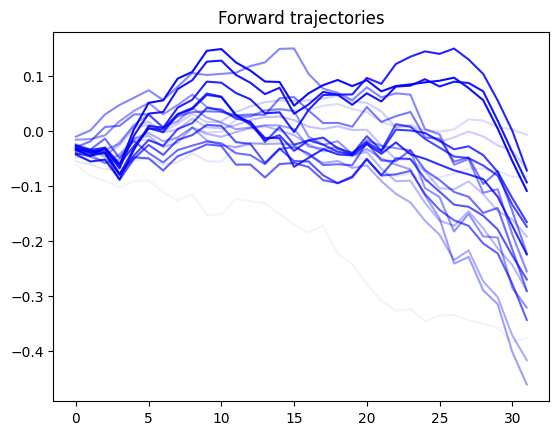

In [13]:
plt.title('Forward trajectories')
for i, path in enumerate(trajectories):
    plt.plot(path, 'b', label=f'{i}', alpha=i/21)
# plt.legend()
plt.show()

## Backwards 

We use a similar techique, except now we also look at the closing layer. Note that it's fairly sparse. 

In [14]:
def obtain_backward(indices, model_serial):
    # Load weights
    model_dicts = torch.load(f'bert-save-1/model_serial_checkpoint_batch_idx={indices}')
    
    # Insert weights into model 
    model_serial.load_state_dict(model_dicts['model_state_dict'])
    model_serial = model_serial.to('cpu')

    # Define a dictionary to store neuron values
    neuron_values = {}
    
    # Define the hook function; hook must be of this form; like wtf why use input as a name? 
    def hook_fn(module, grad_input, grad_output):
        # Access the specific neuron value [0, 0, 0] 
        # Note that within the model, the array passed in [batch, seq_len, embedding dim]
        neuron_value_output = grad_output[0][1, :, :] #.item() # Use the first sample
    
        # Store the neuron value in the dictionary
        layer_name = module.__class__.__name__
        if layer_name not in neuron_values:
            neuron_values[layer_name] = []
        neuron_values[layer_name].append(neuron_value_output)
        
    def hook_fn_close(module, grad_input, grad_output):
        # Access the specific neuron value [0, 0, 0] 
        # Note that within the model, the array passed in [batch, seq_len, embedding dim]
        # print(len(grad_input), len(grad_output))
        # print(grad_input[0].shape)
        # print(grad_output)
        neuron_value_output = grad_output[0] # [0, :, :] #.item()
    
        # Store the neuron value in the dictionary
        layer_name = module.__class__.__name__
        if layer_name not in neuron_values:
            neuron_values[layer_name] = []
        neuron_values[layer_name].append(
            (neuron_value_output, grad_input[0])
        )
    

    # Register the hook function to each encoder layer
    hooks = []
    for i, layer in enumerate(model_serial.serial_nn):
        hook = layer.register_full_backward_hook(hook_fn)
        hooks.append(hook)
    
    hook = model_serial.close_nn_mlm.register_full_backward_hook(hook_fn_close)
    hooks.append(hook)

    # Perform a forward pass
    outputs = model_serial(sample_data, sample_segment_label)
    criterion = nn.CrossEntropyLoss(ignore_index=-100)

    outputs = model_serial(sample_data, sample_segment_label)
    loss = criterion(outputs.reshape(-1, outputs.shape[-1]), 
              sample_target.reshape(-1))

    loss.backward()

    # Remove hooks; 
    for hook in hooks:
        hook.remove()
        
    return np.array(neuron_values['FixDTBlock']), neuron_values['CloseLayerMLM']

In [15]:
btrajectories = []
b_mlm = []
for i in range(0, 16001, 1000): 
    print(i, end=', ')
    p_net, mlm = obtain_backward(i, model_serial)
    btrajectories.append(
        p_net
    )
    b_mlm.append(mlm)

0, 

/tmp/ipykernel_2470142/700095419.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dicts = torch.load(f'bert-save-1/model_serial_checkpoint_batch_idx={indices}')


1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000, 16000, 

Note that the backwards on the closing layer is really sparse, and this is due to the fact that the sample target is also sparse. Compare the figure below (plotting the adjoint in the MLM) and the sample target.

In [34]:
treescope.render_array(b_mlm[0][0][1][1, :, :])


<Arrayviz rendering>

In [35]:
treescope.render_array(sample_target[1] + 100)

<Arrayviz rendering>

torch.Size([4, 96, 30522])
torch.Size([4, 96, 768])
[tensor(2.2924e-07), tensor(1.2688e-07), tensor(4.6462e-09), tensor(1.1250e-09), tensor(6.9787e-10), tensor(1.0835e-09), tensor(1.1282e-09), tensor(1.7722e-09), tensor(8.0381e-10), tensor(7.3146e-10), tensor(4.2318e-10), tensor(4.5875e-10), tensor(3.8864e-10), tensor(1.1198e-09), tensor(3.6615e-09), tensor(3.5232e-09), tensor(2.2384e-09)]
[tensor(-5.8946e-05), tensor(-8.7689e-05), tensor(-0.0001), tensor(-8.7803e-05), tensor(-4.9292e-05), tensor(-2.5796e-06), tensor(2.8154e-05), tensor(0.0001), tensor(0.0003), tensor(0.0005), tensor(0.0007), tensor(0.0006), tensor(0.0007), tensor(0.0008), tensor(0.0009), tensor(0.0010), tensor(0.0012)]


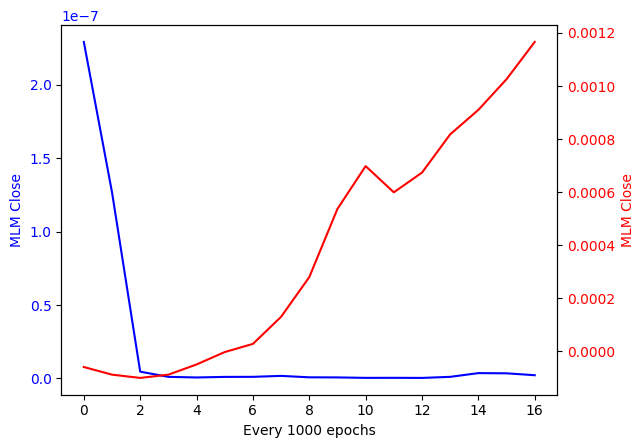

In [62]:
mlm_open = []
mlm_close = []
for i in range(len(b_mlm)):
    mlm_open.append(b_mlm[i][0][0][1, 6, 1]) # Index is batch, token number, vocab number
    mlm_close.append(b_mlm[i][0][1][1, 6, 1]) # Index is batch, token number, embed dimension? 

print(b_mlm[0][0][0].shape)
print(b_mlm[0][0][1].shape)
print(mlm_open)
print(mlm_close)

# Assuming mlm_open and mlm_close are your data series
fig, ax1 = plt.subplots()

# Plot mlm_open on the left y-axis
ax1.plot(mlm_open, color='b', label='MLM Close')
ax1.set_ylabel('MLM Close', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for mlm_close
ax2 = ax1.twinx()
ax2.plot(mlm_close, color='r', label='MLM Close')
ax2.set_ylabel('MLM Close', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax1.set_xlabel('Every 1000 epochs')
plt.show()

Text(0.5, 1.0, 'Adjoint variables')

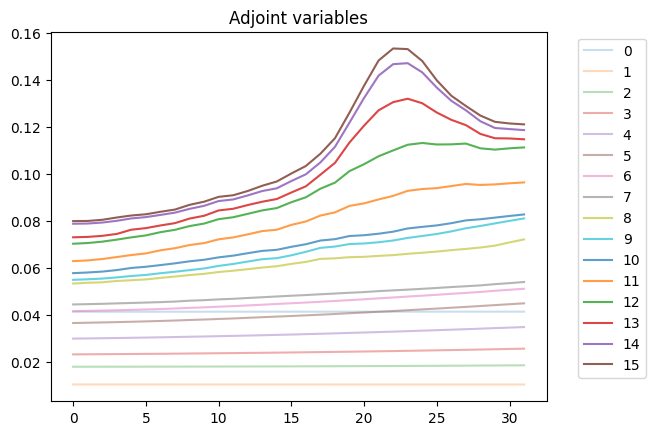

In [61]:

for i, path in enumerate(btrajectories):
    norms = []
    for time in range(32): 
        norms.append(np.linalg.norm(path[time, :, :]))
    plt.plot(norms, label=f'{i}', alpha=min((i + 5)/21, 1))
    if i == 15: 
        break
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Norms')

Text(0.5, 1.0, 'Adjoint variables')

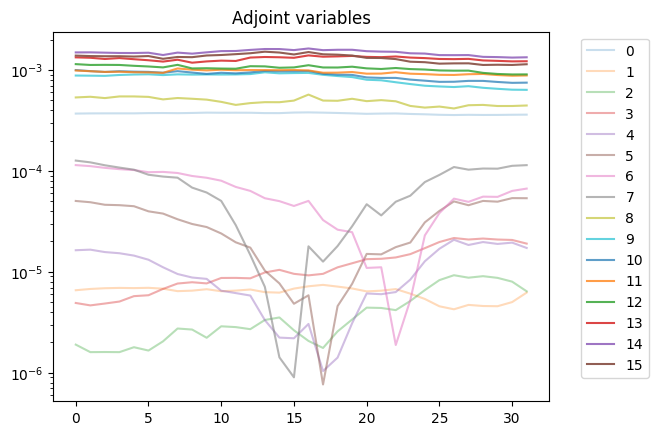

In [56]:
for i, path in enumerate(btrajectories):
    plt.semilogy(np.abs(path[:, 6, 2]), label=f'{i}', alpha=min((i + 5)/21, 1))
    if i == 15: 
        break
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Adjoint variables')

Text(0.5, 1.0, 'Adjoint variables')

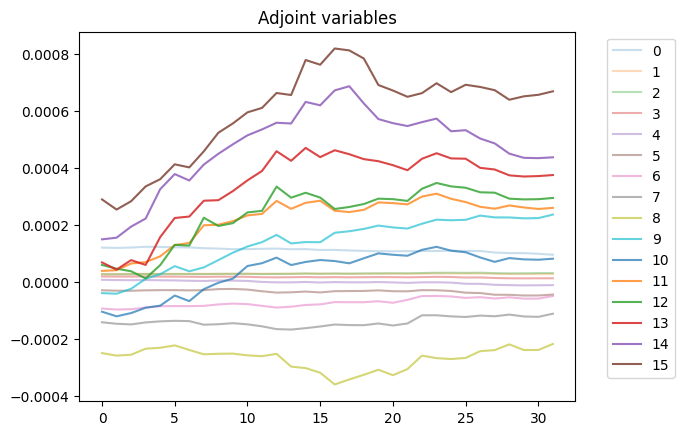

In [46]:
for i, path in enumerate(btrajectories):
    plt.plot((path[:, 6, 3]), label=f'{i}', alpha=min((i + 5)/21, 1))
    if i == 15: 
        break
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Adjoint variables')

Text(0.5, 1.0, 'Adjoint variables')

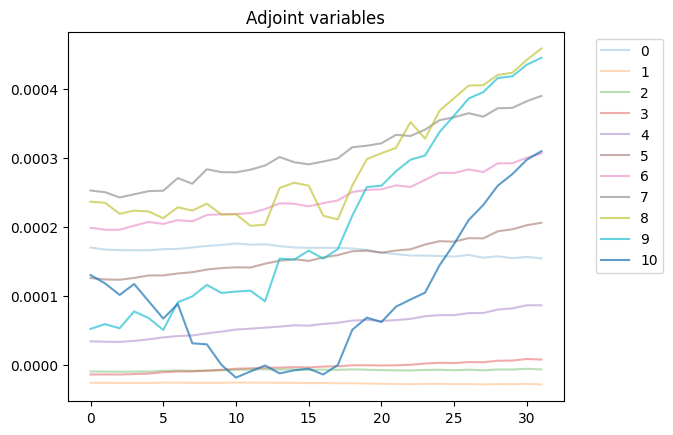

In [52]:
for i, path in enumerate(btrajectories):
    plt.plot((path[:, 6, 20]), label=f'{i}', alpha=min((i + 5)/21, 1))
    if i == 10: 
        break
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title('Adjoint variables')

This seems smooth! Why is convergence breaking down? :( 

But I think it's not ALL smooth. 

In [24]:
for i, layer in enumerate(model.encoder.layer):
    print(layer)
    break

BertLayer(
  (attention): BertAttention(
    (self): BertSdpaSelfAttention(
      (query): Linear(in_features=768, out_features=768, bias=True)
      (key): Linear(in_features=768, out_features=768, bias=True)
      (value): Linear(in_features=768, out_features=768, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (output): BertSelfOutput(
      (dense): Linear(in_features=768, out_features=768, bias=True)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
  (intermediate): BertIntermediate(
    (dense): Linear(in_features=768, out_features=3072, bias=True)
    (intermediate_act_fn): GELUActivation()
  )
  (output): BertOutput(
    (dense): Linear(in_features=3072, out_features=768, bias=True)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)
